In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [32]:
z_dim = 100
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_channels, img_size = 1, 28
os.makedirs("images", exist_ok=True)
os.makedirs("GAN_images", exist_ok=True)


In [30]:
# --- Transforms and Datasets ---
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_cifar = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fashion_dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=transform_mnist)
cifar_dataset = datasets.CIFAR10("./data", train=True, download=True, transform=transform_cifar)

fashion_labels = {"shirt": 6, "pants": 1, "coat": 4}
cifar_labels = {"dog": 5, "cat": 3, "airplane": 0}

# =========================================
# PART 1: GAN for Multiple Classes
# =========================================

In [ ]:
# --- Models ---
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=784):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)



In [ ]:
# --- GAN Training per Class ---
def train_gan(dataset, class_name, label, img_dim, img_channels):
    indices = [i for i, (_, lbl) in enumerate(dataset) if lbl == label][:3000]
    loader = DataLoader(Subset(dataset, indices), batch_size=batch_size, shuffle=True)

    gen = Generator(z_dim, img_dim).to(device)
    disc = Discriminator(img_dim).to(device)
    opt_gen = optim.Adam(gen.parameters(), lr=2e-4)
    opt_disc = optim.Adam(disc.parameters(), lr=2e-4)
    criterion = nn.BCELoss()

    for epoch in range(30):
        for real, _ in loader:
            real = real.view(-1, img_dim).to(device)
            noise = torch.randn((real.size(0), z_dim)).to(device)
            fake = gen(noise)

            disc_real = disc(real).view(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

            disc_fake = disc(fake.detach()).view(-1)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            output = disc(fake).view(-1)
            loss_gen = criterion(output, torch.ones_like(output))

            gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

    # Save samples
    fixed_noise = torch.randn(10, z_dim).to(device)
    fake_images = gen(fixed_noise).view(-1, img_channels, int(np.sqrt(img_dim // img_channels)), int(np.sqrt(img_dim // img_channels)))
    save_image(fake_images * 0.5 + 0.5, f"GAN_images/fake_{class_name}.png", nrow=10)

    real_images = next(iter(loader))[0][:10]
    save_image(real_images * 0.5 + 0.5, f"GAN_images/real_{class_name}.png", nrow=10)

    # Mimic optimization
    target = real_images[0].view(1, -1).to(device)
    mimic_imgs = []
    for i in range(10):  # 🔁 產生 10 張 mimic
        mimic_z = torch.randn((1, z_dim), requires_grad=True, device=device)
        opt = torch.optim.Adam([mimic_z], lr=0.05)

        for _ in range(300):
            fake = gen(mimic_z).view(1, -1)
            loss = F.mse_loss(fake, target)
            opt.zero_grad()
            loss.backward()
            opt.step()
        mimic_img = gen(mimic_z).view(1, img_channels, int(np.sqrt(img_dim // img_channels)), int(np.sqrt(img_dim // img_channels)))
        mimic_imgs.append(mimic_img.detach())

    mimic_imgs = torch.cat(mimic_imgs, dim=0)
    save_image(mimic_imgs * 0.5 + 0.5, f"GAN_images/mimic_{class_name}.png", nrow=10)
    return gen


In [33]:
os.makedirs("saved_models", exist_ok=True)

for cname, lbl in fashion_labels.items():
    gen = train_gan(fashion_dataset, cname, lbl, img_dim=28*28, img_channels=1)
    torch.save(gen.state_dict(), f"saved_models/fashion_gan_{cname}.pth")

for cname, lbl in cifar_labels.items():
    gen = train_gan(cifar_dataset, cname, lbl, img_dim=32*32*3, img_channels=3)
    torch.save(gen.state_dict(), f"saved_models/cifar_gan_{cname}.pth")



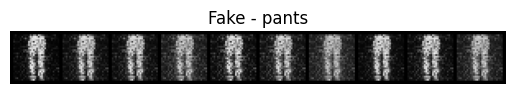

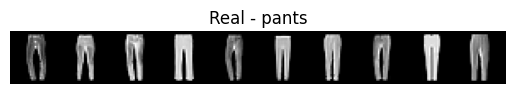

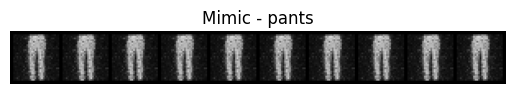

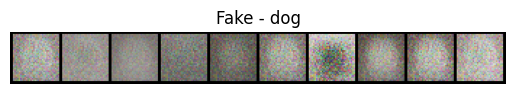

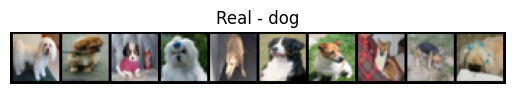

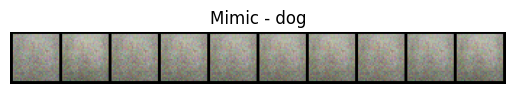

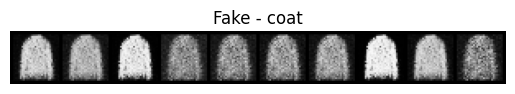

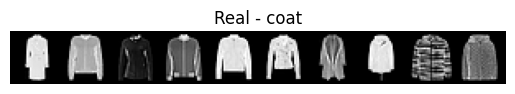

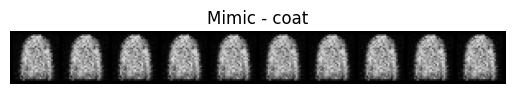

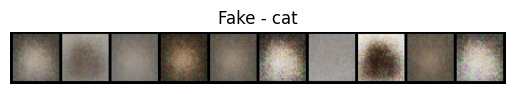

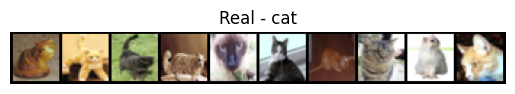

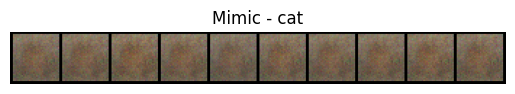

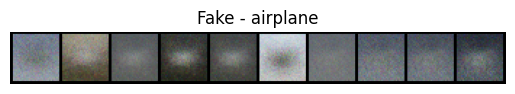

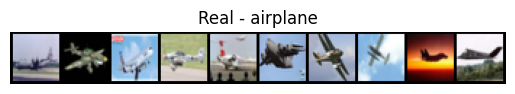

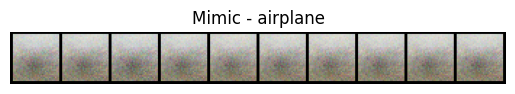

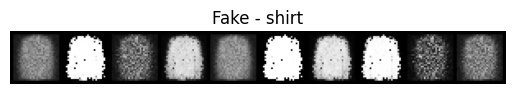

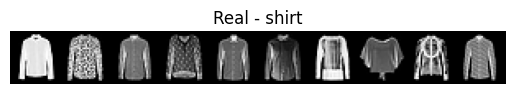

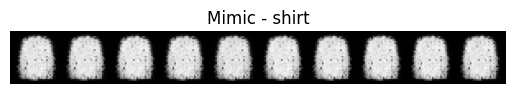

In [34]:
# --- Visualization ---
def show_image(path, title=None):
    img = Image.open(path)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

class_names = {"shirt", "pants", "coat", "dog", "cat", "airplane"}
for name in class_names:
    show_image(f"GAN_images/fake_{name}.png", title=f"Fake - {name}")
    show_image(f"GAN_images/real_{name}.png", title=f"Real - {name}")
    show_image(f"GAN_images/mimic_{name}.png", title=f"Mimic - {name}")


# =========================================
# PART 2: Placeholder for CycleGAN Training
# =========================================

In [20]:
# --------------------------------
# Utils
# --------------------------------
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def show_image(path, title=None):
    from PIL import Image
    import matplotlib.pyplot as plt
    img = Image.open(path)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [21]:
class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class ResNetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=6):
        super().__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        ]

        model += [
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True)
        ]

        for _ in range(n_blocks):
            model += [ResNetBlock(256)]

        model += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, output_nc, kernel_size=7, padding=3),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, input_nc):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [35]:
def train_cycle_gan_cifar(class_A, class_B, label_A, label_B, cifar_dataset, num_epochs=20):
    print(f"\n--- Training {class_A} ↔ {class_B} ---")
    save_dir = f"cycleGan_images/{class_A}_to_{class_B}"
    ensure_dir(save_dir)

    A_loader = DataLoader(
        Subset(cifar_dataset, [i for i, (_, l) in enumerate(cifar_dataset) if l == label_A][:1000]),
        batch_size=32, shuffle=True
    )
    B_loader = DataLoader(
        Subset(cifar_dataset, [i for i, (_, l) in enumerate(cifar_dataset) if l == label_B][:1000]),
        batch_size=32, shuffle=True
    )

    G_A2B = ResNetGenerator(3, 3).to(device)
    G_B2A = ResNetGenerator(3, 3).to(device)
    D_A = PatchDiscriminator(3).to(device)
    D_B = PatchDiscriminator(3).to(device)

    opt_G = torch.optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=2e-4, betas=(0.5, 0.999))
    opt_D_A = torch.optim.Adam(D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_D_B = torch.optim.Adam(D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))

    criterion_GAN = nn.MSELoss()
    criterion_cycle = nn.L1Loss()
    criterion_identity = nn.L1Loss()

    lambda_cycle = 10
    lambda_identity = 5

    for epoch in range(num_epochs):
        for (real_A, _), (real_B, _) in zip(A_loader, B_loader):
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            # Generator forward
            fake_B = G_A2B(real_A)
            fake_A = G_B2A(real_B)
            recov_A = G_B2A(fake_B)
            recov_B = G_A2B(fake_A)
            idt_A = G_B2A(real_A)
            idt_B = G_A2B(real_B)

            # Generator losses
            loss_idt = criterion_identity(idt_A, real_A) * lambda_identity + criterion_identity(idt_B, real_B) * lambda_identity
            loss_GAN = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B))) + criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))
            loss_cycle = criterion_cycle(recov_A, real_A) * lambda_cycle + criterion_cycle(recov_B, real_B) * lambda_cycle
            loss_G = loss_idt + loss_GAN + loss_cycle

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

            # Discriminator A
            loss_D_A = (
                criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A))) +
                criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
            ) * 0.5
            opt_D_A.zero_grad()
            loss_D_A.backward()
            opt_D_A.step()

            # Discriminator B
            loss_D_B = (
                criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B))) +
                criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
            ) * 0.5
            opt_D_B.zero_grad()
            loss_D_B.backward()
            opt_D_B.step()

        print(f"[Epoch {epoch+1}/{num_epochs}] Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}")

        if (epoch + 1) % 10 == 0:
            save_image((real_A[:10] * 0.5 + 0.5), f"{save_dir}/real_A_epoch{epoch+1}.png", nrow=10)
            save_image((fake_B[:10] * 0.5 + 0.5), f"{save_dir}/fake_B_epoch{epoch+1}.png", nrow=10)
            save_image((recov_A[:10] * 0.5 + 0.5), f"{save_dir}/recov_A_epoch{epoch+1}.png", nrow=10)
            save_image((real_B[:10] * 0.5 + 0.5), f"{save_dir}/real_B_epoch{epoch+1}.png", nrow=10)
            save_image((fake_A[:10] * 0.5 + 0.5), f"{save_dir}/fake_A_epoch{epoch+1}.png", nrow=10)
            save_image((recov_B[:10] * 0.5 + 0.5), f"{save_dir}/recov_B_epoch{epoch+1}.png", nrow=10)

            show_image(f"{save_dir}/real_A_epoch{epoch+1}.png", f"{class_A} → real")
            show_image(f"{save_dir}/fake_B_epoch{epoch+1}.png", f"{class_A} → fake {class_B}")
            show_image(f"{save_dir}/recov_A_epoch{epoch+1}.png", f"{class_A} → {class_B} → recov")
            show_image(f"{save_dir}/real_B_epoch{epoch+1}.png", f"{class_B} → real")
            show_image(f"{save_dir}/fake_A_epoch{epoch+1}.png", f"{class_B} → fake {class_A}")
            show_image(f"{save_dir}/recov_B_epoch{epoch+1}.png", f"{class_B} → {class_A} → recov")

            # 🔁 mimic mode
            target = real_A[0].unsqueeze(0).to(device)
            mimic_imgs = []

            for i in range(10):
                mimic_z = torch.randn((1, 3, 32, 32), requires_grad=True, device=device)
                mimic_opt = torch.optim.Adam([mimic_z], lr=0.05)

                for _ in range(200):
                    mimic_fake = G_A2B(mimic_z)
                    loss = F.mse_loss(mimic_fake, target)
                    mimic_opt.zero_grad()
                    loss.backward()
                    mimic_opt.step()

                mimic_imgs.append(mimic_fake.detach())

            mimic_imgs = torch.cat(mimic_imgs, dim=0)
            save_image((mimic_imgs * 0.5 + 0.5), f"{save_dir}/mimic_{epoch+1}.png", nrow=10)
            show_image(f"{save_dir}/mimic_{epoch+1}.png", f"{class_A} mimic in {class_B}")

    os.makedirs("saved_models", exist_ok=True)
    torch.save(G_A2B.state_dict(), f"saved_models/cycle_gan_{class_A}_to_{class_B}.pth")
    torch.save(G_B2A.state_dict(), f"saved_models/cycle_gan_{class_B}_to_{class_A}.pth")





--- Training cat ↔ dog ---
[Epoch 1/20] Loss_G: 8.2070 Loss_D_A: 0.2396 Loss_D_B: 0.2376
[Epoch 2/20] Loss_G: 8.8150 Loss_D_A: 0.2122 Loss_D_B: 0.2258
[Epoch 3/20] Loss_G: 7.6797 Loss_D_A: 0.2246 Loss_D_B: 0.2227
[Epoch 4/20] Loss_G: 7.7357 Loss_D_A: 0.2130 Loss_D_B: 0.1932
[Epoch 5/20] Loss_G: 6.3568 Loss_D_A: 0.2189 Loss_D_B: 0.2182
[Epoch 6/20] Loss_G: 6.1496 Loss_D_A: 0.2309 Loss_D_B: 0.2202
[Epoch 7/20] Loss_G: 6.8482 Loss_D_A: 0.1872 Loss_D_B: 0.2054
[Epoch 8/20] Loss_G: 5.1493 Loss_D_A: 0.1917 Loss_D_B: 0.2036
[Epoch 9/20] Loss_G: 5.1253 Loss_D_A: 0.2132 Loss_D_B: 0.2313
[Epoch 10/20] Loss_G: 4.8975 Loss_D_A: 0.1944 Loss_D_B: 0.2179


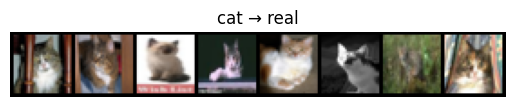

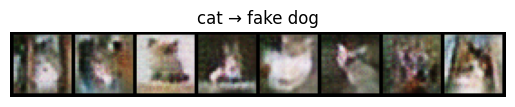

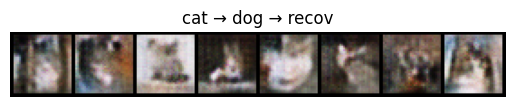

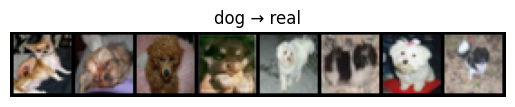

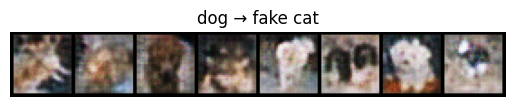

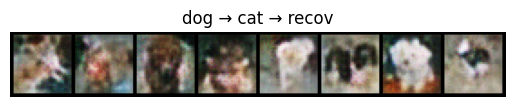

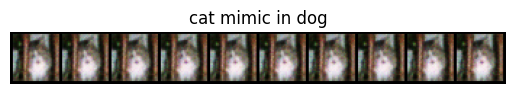

[Epoch 11/20] Loss_G: 5.1355 Loss_D_A: 0.1982 Loss_D_B: 0.2253
[Epoch 12/20] Loss_G: 4.9696 Loss_D_A: 0.2493 Loss_D_B: 0.2010
[Epoch 13/20] Loss_G: 5.7747 Loss_D_A: 0.1720 Loss_D_B: 0.2061
[Epoch 14/20] Loss_G: 5.0987 Loss_D_A: 0.1929 Loss_D_B: 0.1661
[Epoch 15/20] Loss_G: 4.6768 Loss_D_A: 0.1902 Loss_D_B: 0.2063
[Epoch 16/20] Loss_G: 4.7326 Loss_D_A: 0.1943 Loss_D_B: 0.1957
[Epoch 17/20] Loss_G: 5.6945 Loss_D_A: 0.1901 Loss_D_B: 0.2078
[Epoch 18/20] Loss_G: 4.0361 Loss_D_A: 0.1979 Loss_D_B: 0.2175
[Epoch 19/20] Loss_G: 4.9072 Loss_D_A: 0.2252 Loss_D_B: 0.1757
[Epoch 20/20] Loss_G: 5.2527 Loss_D_A: 0.1905 Loss_D_B: 0.1579


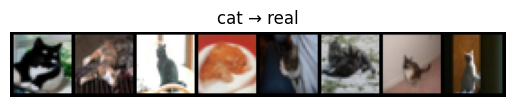

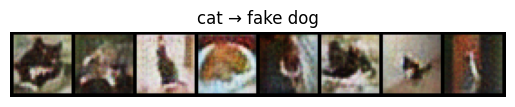

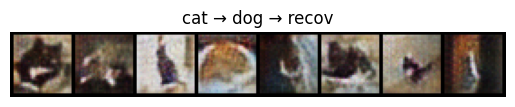

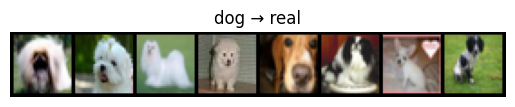

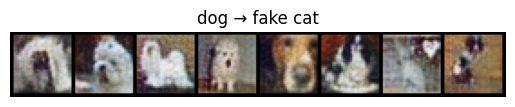

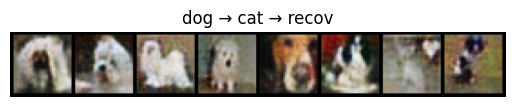

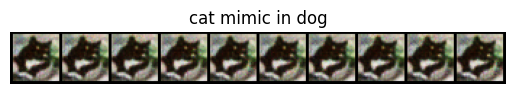


--- Training cat ↔ airplane ---
[Epoch 1/20] Loss_G: 10.5669 Loss_D_A: 0.2362 Loss_D_B: 0.2239
[Epoch 2/20] Loss_G: 8.2362 Loss_D_A: 0.1959 Loss_D_B: 0.1897
[Epoch 3/20] Loss_G: 8.7907 Loss_D_A: 0.2080 Loss_D_B: 0.2184
[Epoch 4/20] Loss_G: 7.8109 Loss_D_A: 0.1929 Loss_D_B: 0.1522
[Epoch 5/20] Loss_G: 6.7971 Loss_D_A: 0.1663 Loss_D_B: 0.1653
[Epoch 6/20] Loss_G: 8.5155 Loss_D_A: 0.1853 Loss_D_B: 0.1874
[Epoch 7/20] Loss_G: 6.2044 Loss_D_A: 0.1883 Loss_D_B: 0.1505
[Epoch 8/20] Loss_G: 7.0578 Loss_D_A: 0.1333 Loss_D_B: 0.1777
[Epoch 9/20] Loss_G: 6.5602 Loss_D_A: 0.1505 Loss_D_B: 0.1245
[Epoch 10/20] Loss_G: 6.4032 Loss_D_A: 0.2100 Loss_D_B: 0.1920


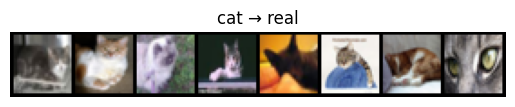

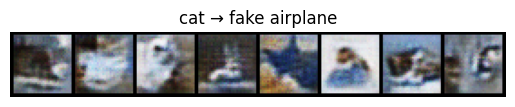

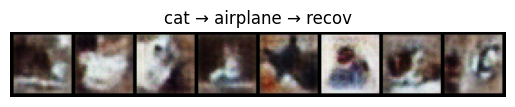

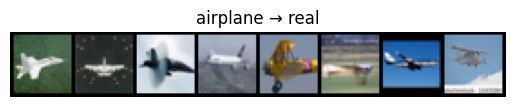

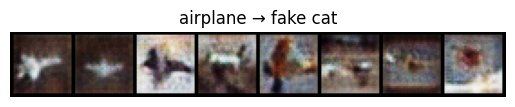

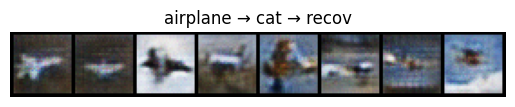

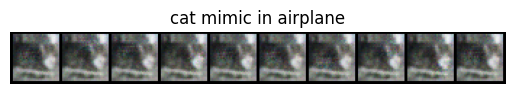

[Epoch 11/20] Loss_G: 5.8284 Loss_D_A: 0.2005 Loss_D_B: 0.1592
[Epoch 12/20] Loss_G: 4.9847 Loss_D_A: 0.2201 Loss_D_B: 0.2383
[Epoch 13/20] Loss_G: 5.1437 Loss_D_A: 0.1768 Loss_D_B: 0.1719
[Epoch 14/20] Loss_G: 5.5025 Loss_D_A: 0.1984 Loss_D_B: 0.1748
[Epoch 15/20] Loss_G: 5.9163 Loss_D_A: 0.2056 Loss_D_B: 0.1598
[Epoch 16/20] Loss_G: 5.3741 Loss_D_A: 0.1350 Loss_D_B: 0.1144
[Epoch 17/20] Loss_G: 5.4066 Loss_D_A: 0.1742 Loss_D_B: 0.1782
[Epoch 18/20] Loss_G: 4.5725 Loss_D_A: 0.1745 Loss_D_B: 0.2212
[Epoch 19/20] Loss_G: 4.6805 Loss_D_A: 0.1760 Loss_D_B: 0.2119
[Epoch 20/20] Loss_G: 5.3131 Loss_D_A: 0.1663 Loss_D_B: 0.1547


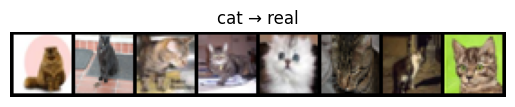

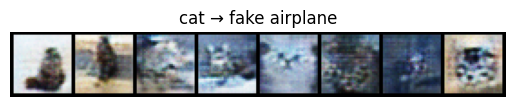

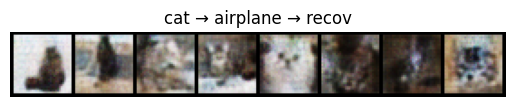

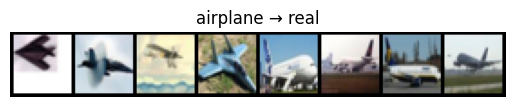

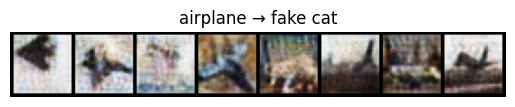

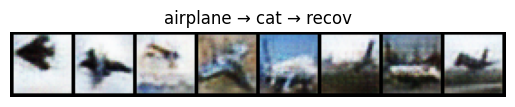

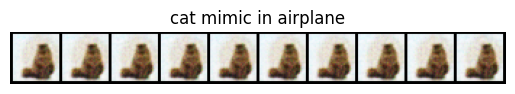


--- Training airplane ↔ dog ---
[Epoch 1/20] Loss_G: 9.0594 Loss_D_A: 0.2073 Loss_D_B: 0.2330
[Epoch 2/20] Loss_G: 8.6034 Loss_D_A: 0.1668 Loss_D_B: 0.1977
[Epoch 3/20] Loss_G: 6.8091 Loss_D_A: 0.2108 Loss_D_B: 0.2224
[Epoch 4/20] Loss_G: 7.0749 Loss_D_A: 0.2187 Loss_D_B: 0.2315
[Epoch 5/20] Loss_G: 7.5690 Loss_D_A: 0.1478 Loss_D_B: 0.1875
[Epoch 6/20] Loss_G: 7.1796 Loss_D_A: 0.1756 Loss_D_B: 0.1757
[Epoch 7/20] Loss_G: 6.2190 Loss_D_A: 0.1632 Loss_D_B: 0.1728
[Epoch 8/20] Loss_G: 6.1558 Loss_D_A: 0.1491 Loss_D_B: 0.1944
[Epoch 9/20] Loss_G: 6.0256 Loss_D_A: 0.1831 Loss_D_B: 0.2208
[Epoch 10/20] Loss_G: 6.0473 Loss_D_A: 0.1553 Loss_D_B: 0.1688


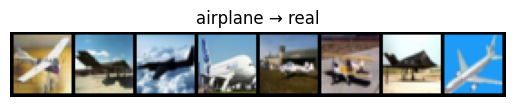

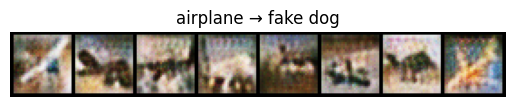

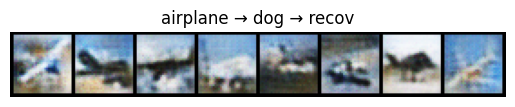

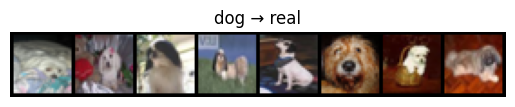

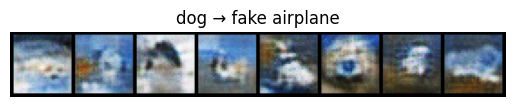

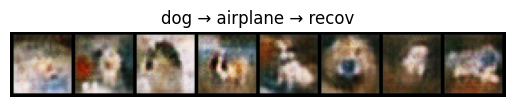

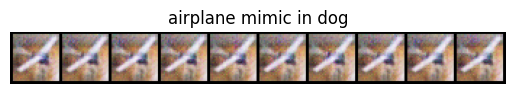

[Epoch 11/20] Loss_G: 6.4875 Loss_D_A: 0.1452 Loss_D_B: 0.1619
[Epoch 12/20] Loss_G: 5.3337 Loss_D_A: 0.1580 Loss_D_B: 0.2043
[Epoch 13/20] Loss_G: 5.4832 Loss_D_A: 0.1174 Loss_D_B: 0.1437
[Epoch 14/20] Loss_G: 4.7303 Loss_D_A: 0.1135 Loss_D_B: 0.1678
[Epoch 15/20] Loss_G: 5.1240 Loss_D_A: 0.1404 Loss_D_B: 0.1776
[Epoch 16/20] Loss_G: 4.9349 Loss_D_A: 0.1180 Loss_D_B: 0.1584
[Epoch 17/20] Loss_G: 5.4898 Loss_D_A: 0.1437 Loss_D_B: 0.2044
[Epoch 18/20] Loss_G: 5.3399 Loss_D_A: 0.1849 Loss_D_B: 0.1976
[Epoch 19/20] Loss_G: 4.6618 Loss_D_A: 0.2012 Loss_D_B: 0.2035
[Epoch 20/20] Loss_G: 5.1645 Loss_D_A: 0.1301 Loss_D_B: 0.1506


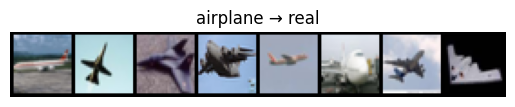

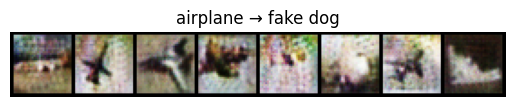

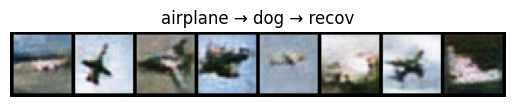

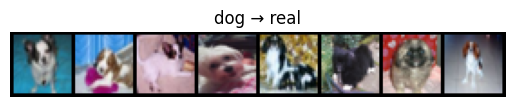

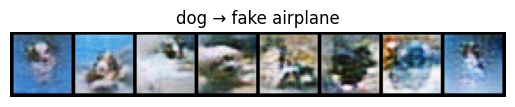

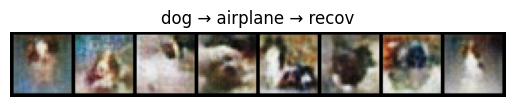

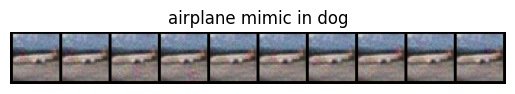

In [37]:
# --- Train all class pairs ---
train_cycle_gan_cifar("cat", "dog", label_A=3, label_B=5, cifar_dataset=cifar_dataset, num_epochs=20)
train_cycle_gan_cifar("cat", "airplane", label_A=3, label_B=0, cifar_dataset=cifar_dataset, num_epochs=20)
train_cycle_gan_cifar("airplane", "dog", label_A=0, label_B=5, cifar_dataset=cifar_dataset, num_epochs=20)



In [38]:
def train_cycle_gan(class_A, class_B, label_A, label_B, num_epochs=20):
    print(f"\n--- Training {class_A} ↔ {class_B} ---")
    save_dir = f"cycleGan_images/{class_A}_to_{class_B}"
    ensure_dir(save_dir)

    A_loader = DataLoader(Subset(fashion_dataset, [i for i, (_, l) in enumerate(fashion_dataset) if l == label_A][:1000]), batch_size=32, shuffle=True)
    B_loader = DataLoader(Subset(fashion_dataset, [i for i, (_, l) in enumerate(fashion_dataset) if l == label_B][:1000]), batch_size=32, shuffle=True)

    G_A2B = ResNetGenerator(3, 3).to(device)
    G_B2A = ResNetGenerator(3, 3).to(device)
    D_A = PatchDiscriminator(3).to(device)
    D_B = PatchDiscriminator(3).to(device)

    opt_G = torch.optim.Adam(list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=2e-4, betas=(0.5, 0.999))
    opt_D_A = torch.optim.Adam(D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_D_B = torch.optim.Adam(D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))

    criterion_GAN = nn.MSELoss()
    criterion_cycle = nn.L1Loss()
    criterion_identity = nn.L1Loss()

    lambda_cycle = 10
    lambda_identity = 5

    for epoch in range(num_epochs):
        for (real_A, _), (real_B, _) in zip(A_loader, B_loader):
            real_A = F.interpolate(real_A.to(device), size=(32, 32)).repeat(1, 3, 1, 1)
            real_B = F.interpolate(real_B.to(device), size=(32, 32)).repeat(1, 3, 1, 1)

            fake_B = G_A2B(real_A)
            fake_A = G_B2A(real_B)
            recov_A = G_B2A(fake_B)
            recov_B = G_A2B(fake_A)
            idt_A = G_B2A(real_A)
            idt_B = G_A2B(real_B)

            loss_idt = criterion_identity(idt_A, real_A) * lambda_identity + criterion_identity(idt_B, real_B) * lambda_identity
            loss_GAN = criterion_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B))) + criterion_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))
            loss_cycle = criterion_cycle(recov_A, real_A) * lambda_cycle + criterion_cycle(recov_B, real_B) * lambda_cycle
            loss_G = loss_idt + loss_GAN + loss_cycle

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

            # Discriminators
            loss_D_A = (
                criterion_GAN(D_A(real_A), torch.ones_like(D_A(real_A))) +
                criterion_GAN(D_A(fake_A.detach()), torch.zeros_like(D_A(fake_A)))
            ) * 0.5
            opt_D_A.zero_grad()
            loss_D_A.backward()
            opt_D_A.step()

            loss_D_B = (
                criterion_GAN(D_B(real_B), torch.ones_like(D_B(real_B))) +
                criterion_GAN(D_B(fake_B.detach()), torch.zeros_like(D_B(fake_B)))
            ) * 0.5
            opt_D_B.zero_grad()
            loss_D_B.backward()
            opt_D_B.step()

        print(f"[Epoch {epoch+1}/{num_epochs}] Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}")

        if (epoch + 1) % 10 == 0:
            save_image((real_A[:10] * 0.5 + 0.5), f"{save_dir}/real_A_epoch{epoch+1}.png", nrow=10)
            save_image((fake_B[:10] * 0.5 + 0.5), f"{save_dir}/fake_B_epoch{epoch+1}.png", nrow=10)
            save_image((recov_A[:10] * 0.5 + 0.5), f"{save_dir}/recov_A_epoch{epoch+1}.png", nrow=10)
            save_image((real_B[:10] * 0.5 + 0.5), f"{save_dir}/real_B_epoch{epoch+1}.png", nrow=10)
            save_image((fake_A[:10] * 0.5 + 0.5), f"{save_dir}/fake_A_epoch{epoch+1}.png", nrow=10)
            save_image((recov_B[:10] * 0.5 + 0.5), f"{save_dir}/recov_B_epoch{epoch+1}.png", nrow=10)
            show_image(f"{save_dir}/real_A_epoch{epoch+1}.png", f"{class_A} → real")
            show_image(f"{save_dir}/fake_B_epoch{epoch+1}.png", f"{class_A} → fake {class_B}")
            show_image(f"{save_dir}/recov_A_epoch{epoch+1}.png", f"{class_A} → {class_B} → recov")
            show_image(f"{save_dir}/real_B_epoch{epoch+1}.png", f"{class_B} → real")
            show_image(f"{save_dir}/fake_A_epoch{epoch+1}.png", f"{class_B} → fake {class_A}")
            show_image(f"{save_dir}/recov_B_epoch{epoch+1}.png", f"{class_B} → {class_A} → recov")
            # Optional mimic for CycleGAN
            target = real_A[0].unsqueeze(0).to(device)
            mimic_imgs = []

            for i in range(10):  # 🔁 產生 10 張 mimic
                mimic_z = torch.randn((1, 3, 32, 32), requires_grad=True, device=device)
                mimic_opt = torch.optim.Adam([mimic_z], lr=0.05)

                for _ in range(200):
                    mimic_fake = G_A2B(mimic_z)
                    loss = F.mse_loss(mimic_fake, target)
                    mimic_opt.zero_grad()
                    loss.backward()
                    mimic_opt.step()

                mimic_imgs.append(mimic_fake.detach())

            # 拼接並儲存 mimic 結果
            mimic_imgs = torch.cat(mimic_imgs, dim=0)
            save_image((mimic_imgs * 0.5 + 0.5), f"{save_dir}/mimic_{epoch+1}.png", nrow=10)
            show_image(f"{save_dir}/mimic_{epoch+1}.png", f"{class_A} mimic in {class_B}")

    os.makedirs("saved_models", exist_ok=True)
    torch.save(G_A2B.state_dict(), f"saved_models/cycle_gan_{class_A}_to_{class_B}.pth")
    torch.save(G_B2A.state_dict(), f"saved_models/cycle_gan_{class_B}_to_{class_A}.pth")



--- Training shirts ↔ pant ---
[Epoch 1/10] Loss_G: 6.6429 Loss_D_A: 0.2306 Loss_D_B: 0.1863
[Epoch 2/10] Loss_G: 5.6430 Loss_D_A: 0.1700 Loss_D_B: 0.1529
[Epoch 3/10] Loss_G: 4.4620 Loss_D_A: 0.1895 Loss_D_B: 0.1438
[Epoch 4/10] Loss_G: 5.7063 Loss_D_A: 0.2382 Loss_D_B: 0.1361
[Epoch 5/10] Loss_G: 4.2523 Loss_D_A: 0.2048 Loss_D_B: 0.1490
[Epoch 6/10] Loss_G: 3.6172 Loss_D_A: 0.1967 Loss_D_B: 0.1895
[Epoch 7/10] Loss_G: 4.8421 Loss_D_A: 0.1975 Loss_D_B: 0.1614
[Epoch 8/10] Loss_G: 3.4160 Loss_D_A: 0.2217 Loss_D_B: 0.1526
[Epoch 9/10] Loss_G: 3.8724 Loss_D_A: 0.2067 Loss_D_B: 0.1768
[Epoch 10/10] Loss_G: 3.2813 Loss_D_A: 0.1998 Loss_D_B: 0.1888


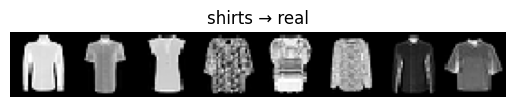

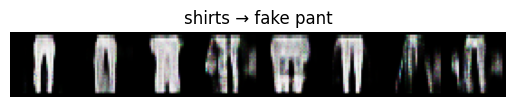

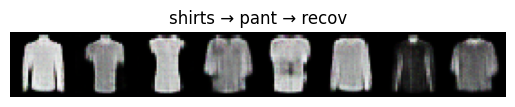

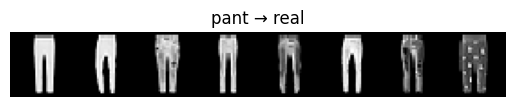

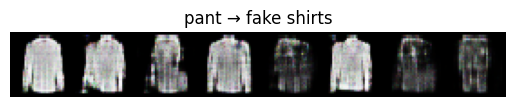

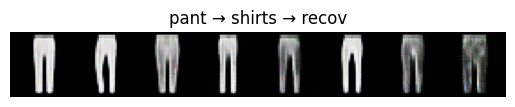

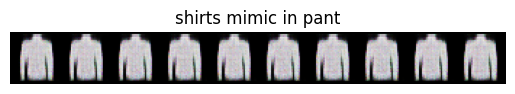


--- Training shirts ↔ coat ---
[Epoch 1/10] Loss_G: 7.3855 Loss_D_A: 0.2005 Loss_D_B: 0.2329
[Epoch 2/10] Loss_G: 5.4726 Loss_D_A: 0.2063 Loss_D_B: 0.2220
[Epoch 3/10] Loss_G: 5.0862 Loss_D_A: 0.1835 Loss_D_B: 0.1870
[Epoch 4/10] Loss_G: 4.5127 Loss_D_A: 0.2305 Loss_D_B: 0.2374
[Epoch 5/10] Loss_G: 5.8683 Loss_D_A: 0.1848 Loss_D_B: 0.1558
[Epoch 6/10] Loss_G: 4.1335 Loss_D_A: 0.1758 Loss_D_B: 0.1914
[Epoch 7/10] Loss_G: 4.1505 Loss_D_A: 0.2012 Loss_D_B: 0.2289
[Epoch 8/10] Loss_G: 3.5337 Loss_D_A: 0.1700 Loss_D_B: 0.1681
[Epoch 9/10] Loss_G: 3.7621 Loss_D_A: 0.1730 Loss_D_B: 0.1447
[Epoch 10/10] Loss_G: 3.5511 Loss_D_A: 0.1885 Loss_D_B: 0.1810


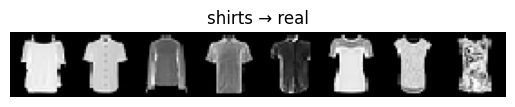

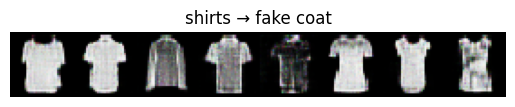

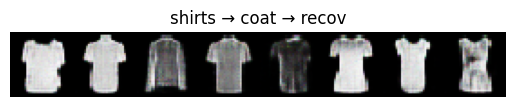

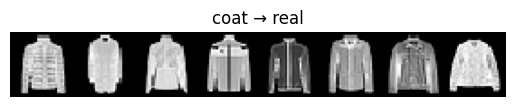

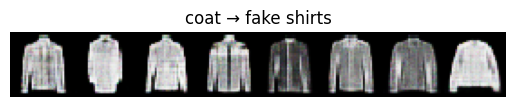

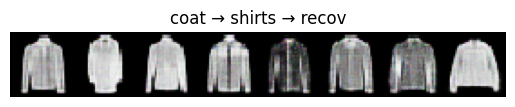

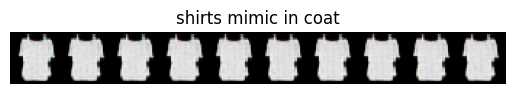


--- Training pant ↔ coat ---
[Epoch 1/10] Loss_G: 6.3932 Loss_D_A: 0.1536 Loss_D_B: 0.1886
[Epoch 2/10] Loss_G: 5.2693 Loss_D_A: 0.1782 Loss_D_B: 0.1769
[Epoch 3/10] Loss_G: 4.5564 Loss_D_A: 0.1751 Loss_D_B: 0.1858
[Epoch 4/10] Loss_G: 4.7450 Loss_D_A: 0.2041 Loss_D_B: 0.1929
[Epoch 5/10] Loss_G: 3.9356 Loss_D_A: 0.2101 Loss_D_B: 0.2073
[Epoch 6/10] Loss_G: 3.3410 Loss_D_A: 0.1950 Loss_D_B: 0.2126
[Epoch 7/10] Loss_G: 3.4517 Loss_D_A: 0.1911 Loss_D_B: 0.2379
[Epoch 8/10] Loss_G: 3.2225 Loss_D_A: 0.1929 Loss_D_B: 0.2115
[Epoch 9/10] Loss_G: 3.7733 Loss_D_A: 0.2330 Loss_D_B: 0.2241
[Epoch 10/10] Loss_G: 3.0973 Loss_D_A: 0.2087 Loss_D_B: 0.2136


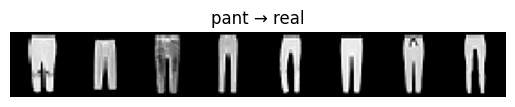

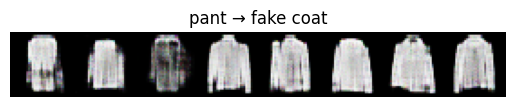

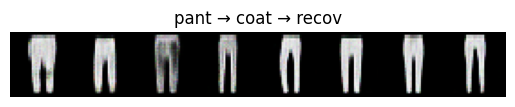

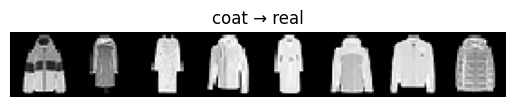

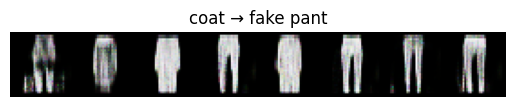

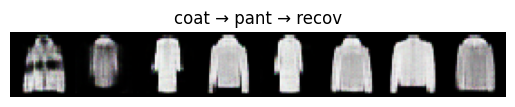

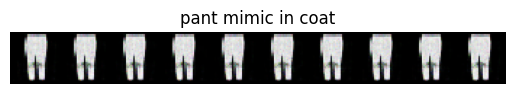

In [39]:
train_cycle_gan("shirts", "pant", label_A=6, label_B=1, num_epochs=10)
train_cycle_gan("shirts", "coat", label_A=6, label_B=4, num_epochs=10)
train_cycle_gan("pant", "coat", label_A=1, label_B=4, num_epochs=10)


# =========================================
# PART 3: Visual Comparison
# =========================================

In [ ]:
def mimic(generator, target_img, label=None, model_type="gan", save_path="mimic_result.png", num_steps=300):
    """
    利用一個隨機潛在向量，通過反向傳播來模仿 target_img
    - model_type: 'gan' or 'cyclegan'
    """
    generator.eval()
    if model_type == "gan":
        z = torch.randn((1, 100), requires_grad=True, device=device)
        optimizer = torch.optim.Adam([z], lr=0.05)
    else:  # CycleGAN
        z = torch.randn((1, 3, 32, 32), requires_grad=True, device=device)
        optimizer = torch.optim.Adam([z], lr=0.05)

    target = target_img.unsqueeze(0).to(device)

    for step in range(num_steps):
        optimizer.zero_grad()
        if model_type == "gan":
            fake = generator(z, label)
        else:
            fake = generator(z)
        loss = F.mse_loss(fake, target)
        loss.backward()
        optimizer.step()

    save_image((fake * 0.5 + 0.5), save_path)
    print(f"[{model_type.upper()}] mimic loss: {loss.item():.4f}")
    show_image(save_path, f"{model_type.upper()} mimic result")

# --- 模擬比較實驗 ---
# 選擇一張圖片：例如 shirt
def run_mimic_comparison(fixed_label=6, class_name="shirt"):
    sample_loader = DataLoader(Subset(fashion_dataset, [i for i, (_, l) in enumerate(fashion_dataset) if l == fixed_label][:1]), batch_size=1)
    img, _ = next(iter(sample_loader))
    img = F.interpolate(img, size=(32, 32)).repeat(1, 3, 1, 1).squeeze(0).to(device)

    # GAN mimic
    mimic(cgan_G, img, label=fixed_label, model_type="gan", save_path=f"mimic_{class_name}_gan.png")

    # CycleGAN mimic
    mimic(cycle_G, img, model_type="cyclegan", save_path=f"mimic_{class_name}_cyclegan.png")



In [40]:
import torch
import torch.nn.functional as F
from torchvision.utils import save_image
import os

def run_mimic_comparison(label, class_name, pair_class="coat"):
    """
    Compare mimic results from CGAN and CycleGAN for a given class.
    """
    print(f"\n--- Mimic Comparison: {class_name} ---")

    # === CGAN Generator ===
    cgan_G = Generator(z_dim, 28*28).to(device)
    cgan_G.load_state_dict(torch.load(f"saved_models/fashion_gan_{class_name}.pth"))
    cgan_G.eval()

    # === CycleGAN Generator (class_name → pair_class) ===
    cycle_G = ResNetGenerator(3, 3).to(device)
    cycle_G.load_state_dict(torch.load(f"saved_models/cycle_gan_{class_name}_to_{pair_class}.pth"))
    cycle_G.eval()

    # === Dataset: pick real image of the class ===
    target = None
    for img, lbl in fashion_dataset:
        if lbl == label:
            target = img.unsqueeze(0).to(device)
            break
    if target is None:
        print(f"No sample found for label {label}")
        return

    # === CGAN mimic (optimize z) ===
    mimic_z = torch.randn((1, z_dim), requires_grad=True, device=device)
    opt = torch.optim.Adam([mimic_z], lr=0.05)

    for _ in range(300):
        fake = cgan_G(mimic_z).view(1, 1, 28, 28)
        loss = F.mse_loss(fake, target)
        opt.zero_grad()
        loss.backward()
        opt.step()

    mimic_cgan_img = fake.detach()
    save_image(mimic_cgan_img * 0.5 + 0.5, f"images/mimic_cgan_{class_name}.png")

    # === CycleGAN mimic (optimize image directly) ===
    mimic_img = torch.randn((1, 3, 32, 32), requires_grad=True, device=device)
    opt_mimic = torch.optim.Adam([mimic_img], lr=0.05)

    target_up = F.interpolate(target, size=(32, 32)).repeat(1, 3, 1, 1)

    for _ in range(200):
        fake = cycle_G(mimic_img)
        loss = F.mse_loss(fake, target_up)
        opt_mimic.zero_grad()
        loss.backward()
        opt_mimic.step()

    mimic_cycle_img = fake.detach()
    save_image(mimic_cycle_img * 0.5 + 0.5, f"images/mimic_cycle_{class_name}.png")

    # === Also save the real image ===
    save_image(target * 0.5 + 0.5, f"images/mimic_real_{class_name}.png")

    print(f"Saved: mimic_cgan_{class_name}.png | mimic_cycle_{class_name}.png | real")





In [41]:
run_mimic_comparison(6, "shirt", pair_class="coat")
run_mimic_comparison(4, "coat", pair_class="pants")
run_mimic_comparison(1, "pants", pair_class="shirt")



--- Mimic Comparison: shirt ---
Saved: mimic_cgan_shirt.png | mimic_cycle_shirt.png | real

--- Mimic Comparison: coat ---
Saved: mimic_cgan_coat.png | mimic_cycle_coat.png | real

--- Mimic Comparison: pants ---
Saved: mimic_cgan_pants.png | mimic_cycle_pants.png | real


#Part 4: Comparison of output quality and behavior of GAN vs CycleGAN

🔍 Comparing GAN vs CycleGAN outputs for mimic mode


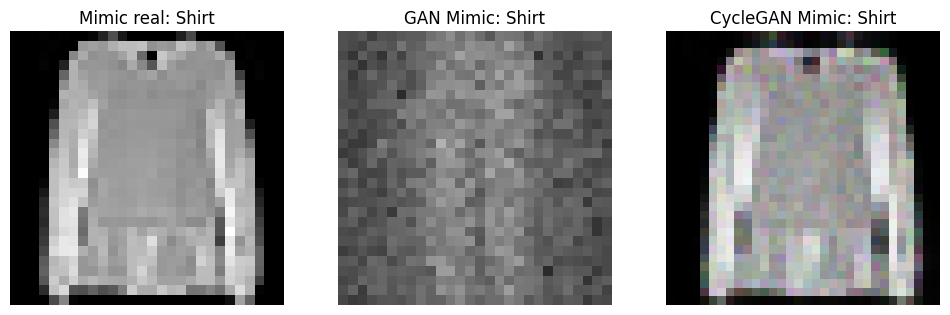

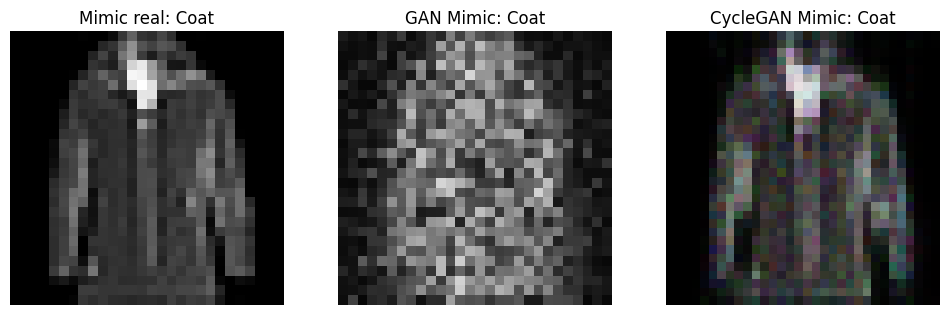

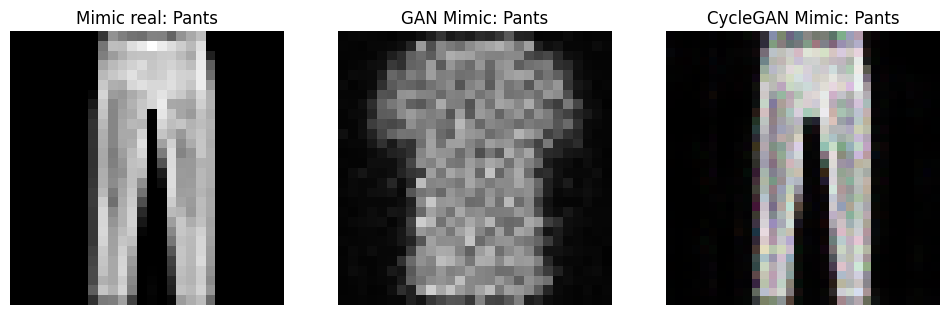

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def load_and_show_images(image_paths, titles, nrow=3):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(4 * len(image_paths), 4))
    if len(image_paths) == 1:
        axes = [axes]
    for ax, path, title in zip(axes, image_paths, titles):
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.show()

# 比較每個類別下的 mimic 結果
def compare_outputs():
    print("🔍 Comparing GAN vs CycleGAN outputs for mimic mode")

    # Shirt comparison
    load_and_show_images(
        ["images/mimic_real_shirt.png","images/mimic_cgan_shirt.png", "images/mimic_cycle_shirt.png"],
        ["Mimic real: Shirt","GAN Mimic: Shirt", "CycleGAN Mimic: Shirt"]
    )

    # Coat comparison
    load_and_show_images(
        ["images/mimic_real_coat.png","images/mimic_cgan_coat.png", "images/mimic_cycle_coat.png"],
        ["Mimic real: Coat","GAN Mimic: Coat", "CycleGAN Mimic: Coat"]
    )

    # Pants comparison
    load_and_show_images(
        ["images/mimic_real_pants.png","images/mimic_cgan_pants.png", "images/mimic_cycle_pants.png"],
        ["Mimic real: Pants","GAN Mimic: Pants", "CycleGAN Mimic: Pants"]
    )

compare_outputs()
